In [5]:
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns

In [589]:
def plot_benchmarking_metrics(fig_title,
                              df,
                              y_col_name,
                              save_fig=False,
                              save_dir="../figures",
                              file_name="benchmarking_metrics.png"):
    fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
    fig.suptitle(fig_title)
    
    # Graph Connectivity Distance
    sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y=y_col_name)
    axes[0, 0].set_title("GCD")

    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y=y_col_name)
    axes[0, 1].set_title("MLNMI")

    # Cell-Type Affinity Distance
    sns.boxplot(data=df, ax=axes[1, 0], x="cad", y=y_col_name)
    axes[1, 0].set_title("CAD")

    # Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
    sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y=y_col_name)
    axes[1, 1].set_title("ARCLISI")

    # Cell Classification Accuracy
    sns.boxplot(data=df, ax=axes[2, 0], x="cca", y=y_col_name)
    axes[2, 0].set_title("CCA")

    # Gene Expression Regression Mean Squared Error
    sns.boxplot(data=df, ax=axes[2, 1], x="germse", y=y_col_name)
    axes[2, 1].set_title("GERMSE")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.5,
                        wspace=0.4,
                        hspace=0.4)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}_{current_timestamp}.png",
                    bbox_inches='tight')

In [656]:
def plot_eval_metrics(fig_title,
                      df,
                      y_col_name,
                      save_fig=False,
                      save_dir="../figures",
                      file_name="benchmarking_metrics.png"):
    # Compute evaluation metric ranks and use total rank for sorting
    val_mse_score_ranks = (df.groupby([y_col_name])
                           ["val_mse_score"].mean().rank(ascending=True)
                           .rename("val_mse_score_rank"))
    val_best_acc_score_ranks = (df.groupby([y_col_name])
                                ["val_best_acc_score"].mean().rank(ascending=False)
                                .rename("val_best_acc_score_rank"))
    df = df.merge(val_mse_score_ranks, on=[y_col_name])
    df = df.merge(val_best_acc_score_ranks, on=[y_col_name])
    df["val_total_score_rank"] = (df["val_mse_score_rank"] + 
                                  df["val_best_acc_score_rank"]).rank(ascending=True)

    df.sort_values(by=["val_total_score_rank", y_col_name],
                   inplace=True,
                   ascending=False)
    
    fig, axes = plt.subplots(3, 1, sharey=True, figsize=(10, 20))
    fig.suptitle(fig_title, fontsize=15)
    
    # Graph Connectivity Distance
    sns.boxplot(data=df, ax=axes[0], x="val_best_acc_score", y=y_col_name)
    axes[0].set_title("Edge Reconstruction Balanced Accuracy")

    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[1], x="val_mse_score", y=y_col_name)
    axes[1].set_title("Gene Expression Reconstruction Mean Squared Error")
    
    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[2], x="ratio_active_gps", y=y_col_name)
    axes[2].set_title("Ratio of Active Gene Programs")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.95,
                        wspace=0.175,
                        hspace=0.175)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}",
                    bbox_inches='tight')

In [647]:
experiment_name = "benchmark_active_gps"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [648]:
def get_loss_weights(row):  
    return f"edge_{row['lambda_edge_recon_']}_+_gene_expr_{row['lambda_gene_expr_recon_']}_+_group_lasso_{row['lambda_group_lasso_']}"

df["loss_weights"] = df.apply(lambda row: get_loss_weights(row), axis=1)

def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))

df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

def get_active_gp_group_lasso_comb(row):
    return f"active_gp_thresh_{row['active_gp_thresh_ratio_']}_+_group_lasso_{row['lambda_group_lasso_']}"

df["active_gp_group_lasso_comb"] = df.apply(lambda row: get_active_gp_group_lasso_comb(row), axis=1)

In [660]:
import numpy as np
from datetime import datetime
import os

In [650]:
# df = df[df["active_gp_thresh_ratio_"].astype(float) == 0.01]
df = df[(df["lambda_edge_recon_"].astype(float) == 1.0) & 
        (df["lambda_gene_expr_recon_"].astype(float) == 1.0) &
        (df["n_active_gps"].notna())]

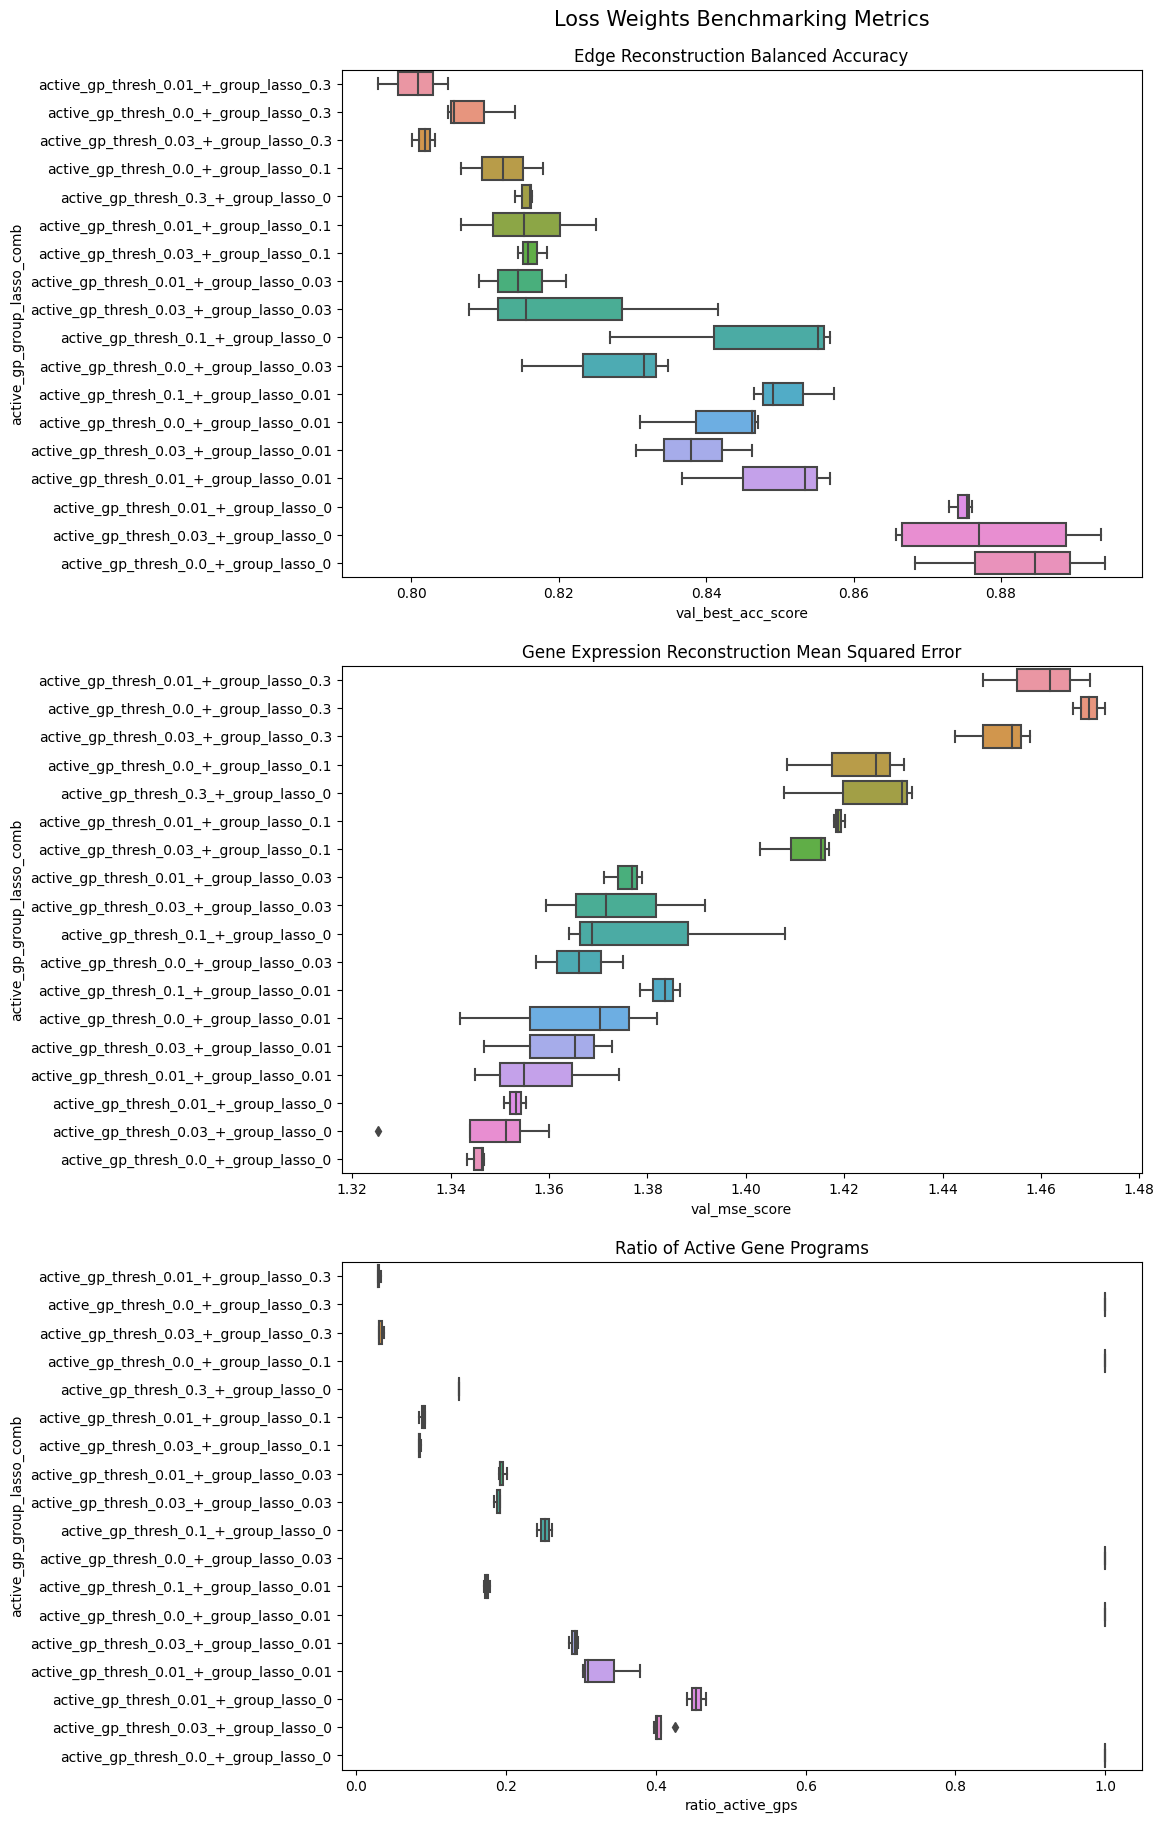

In [661]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="active_gp_group_lasso_comb",
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=True)

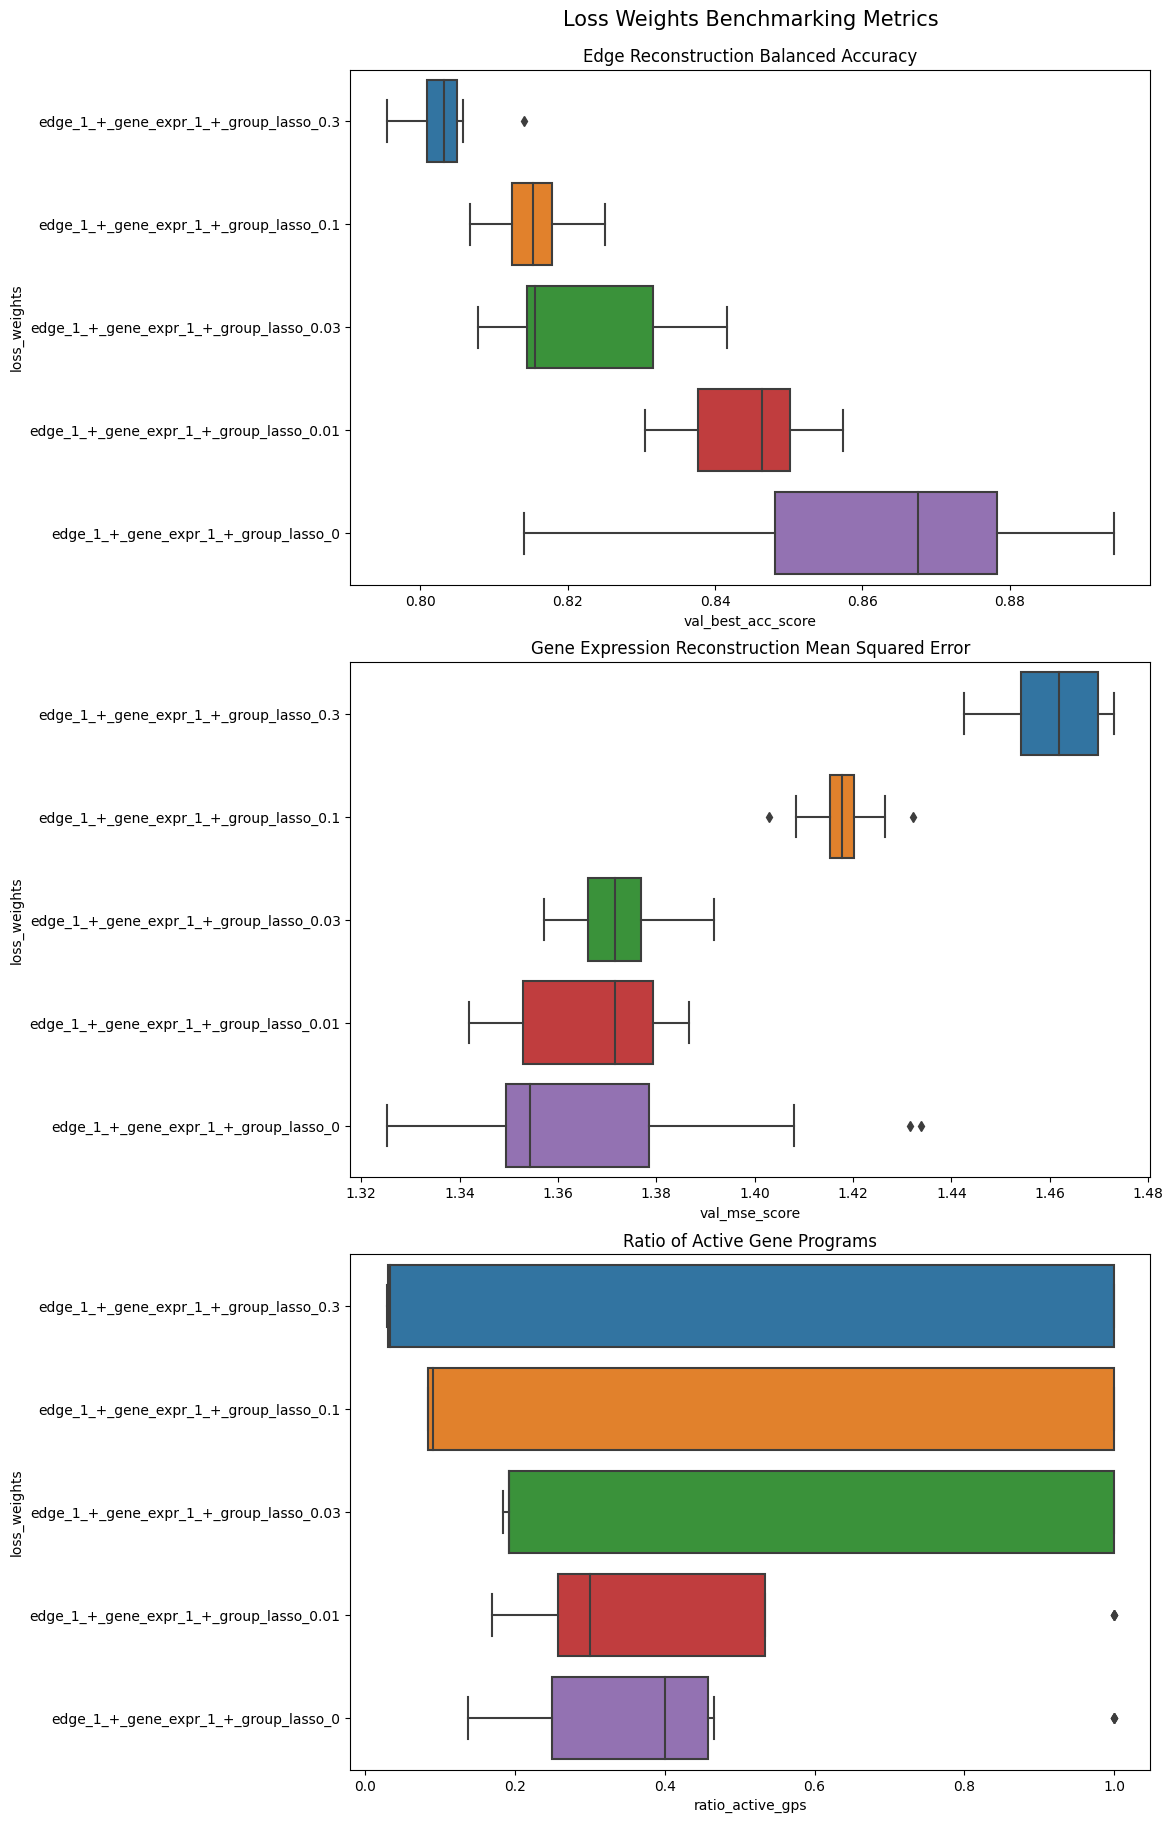

In [645]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="loss_weights",
                  save_fig=False)

In [ ]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="active_gp_group_lasso_comb",
                  save_fig=False)

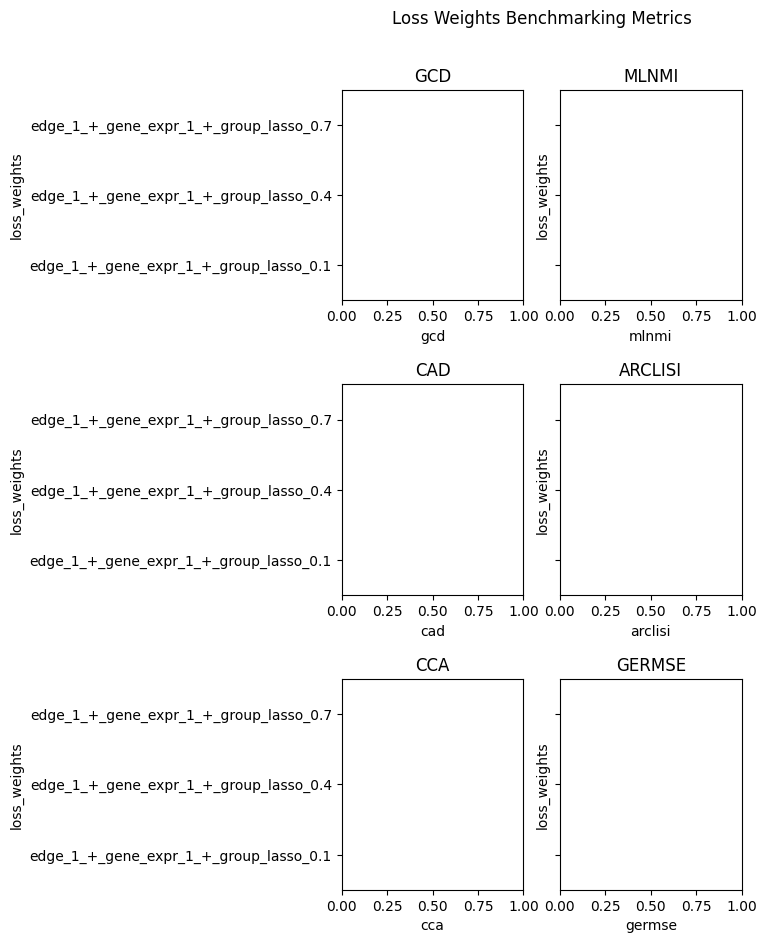

In [256]:
plot_benchmarking_metrics(fig_title="Loss Weights Benchmarking Metrics",
                          df=df,
                          y_col_name="loss_weights",
                          save_fig=False)

<AxesSubplot: xlabel='test_best_acc_score', ylabel='loss_weights'>

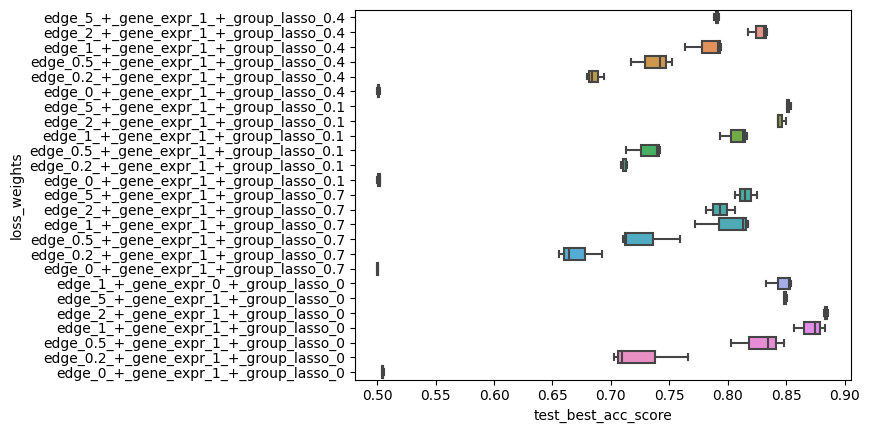

In [199]:
sns.boxplot(data=df, x="test_best_acc_score", y="loss_weights")

In [3]:
def get_recon_loss_inclusion(row):  
    if row["include_edge_recon_loss_"] == "True" and row["include_gene_expr_recon_loss_"] == "True":
        return "edge_+_gene_expr"
    elif row["include_edge_recon_loss_"] == "True" and row["include_gene_expr_recon_loss_"] == "False":
        return "only_edge"
    elif row["include_edge_recon_loss_"] == "False" and row["include_gene_expr_recon_loss_"] == "True":
        return "only_gene_expr"
    return "none"

df["recon_loss_inclusions"] = df.apply(lambda row: get_recon_loss_inclusion(row), axis=1)

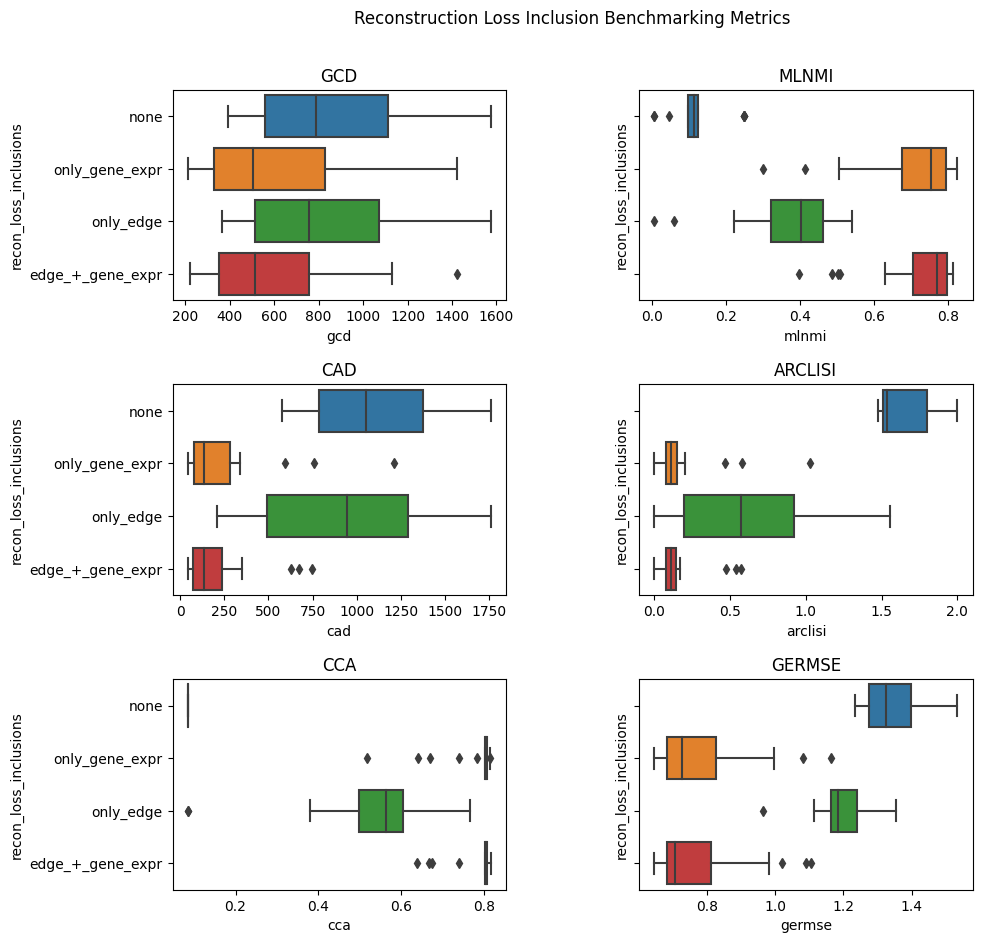

In [6]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Reconstruction Loss Inclusion Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="recon_loss_inclusions")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="recon_loss_inclusions")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="recon_loss_inclusions")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="recon_loss_inclusions")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="recon_loss_inclusions")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="recon_loss_inclusions")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [17]:
experiment_name = "benchmark_gene_expr_recon"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [18]:
def get_gene_expr_recon_components(row):  
    if row["node_label_method_"] == "self" and row["conv_layer_encoder_"] == "gcnconv":
        return "self_+_nb"
    elif row["node_label_method_"] == "self" and row["gene_expr_recon_dist_"] == "zinb":
        return "self_+_zinb"
    elif row["node_label_method_"] == "one-hop-sum" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-sum_+_nb"
    elif row["node_label_method_"] == "one-hop-sum" and row["gene_expr_recon_dist_"] == "zinb":
        return "one-hop-sum_+_zinb"
    elif row["node_label_method_"] == "one-hop-norm" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-norm_+_nb"
    elif row["node_label_method_"] == "one-hop-norm" and row["gene_expr_recon_dist_"] == "zinb":
        return "one-hop-norm_+_zinb"
    elif row["node_label_method_"] == "one-hop-attention" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-attention_+_nb"
    return "one-hop-attention_+_zinb"

df["gene_expr_recon_components"] = df.apply(lambda row: get_gene_expr_recon_components(row), axis=1)

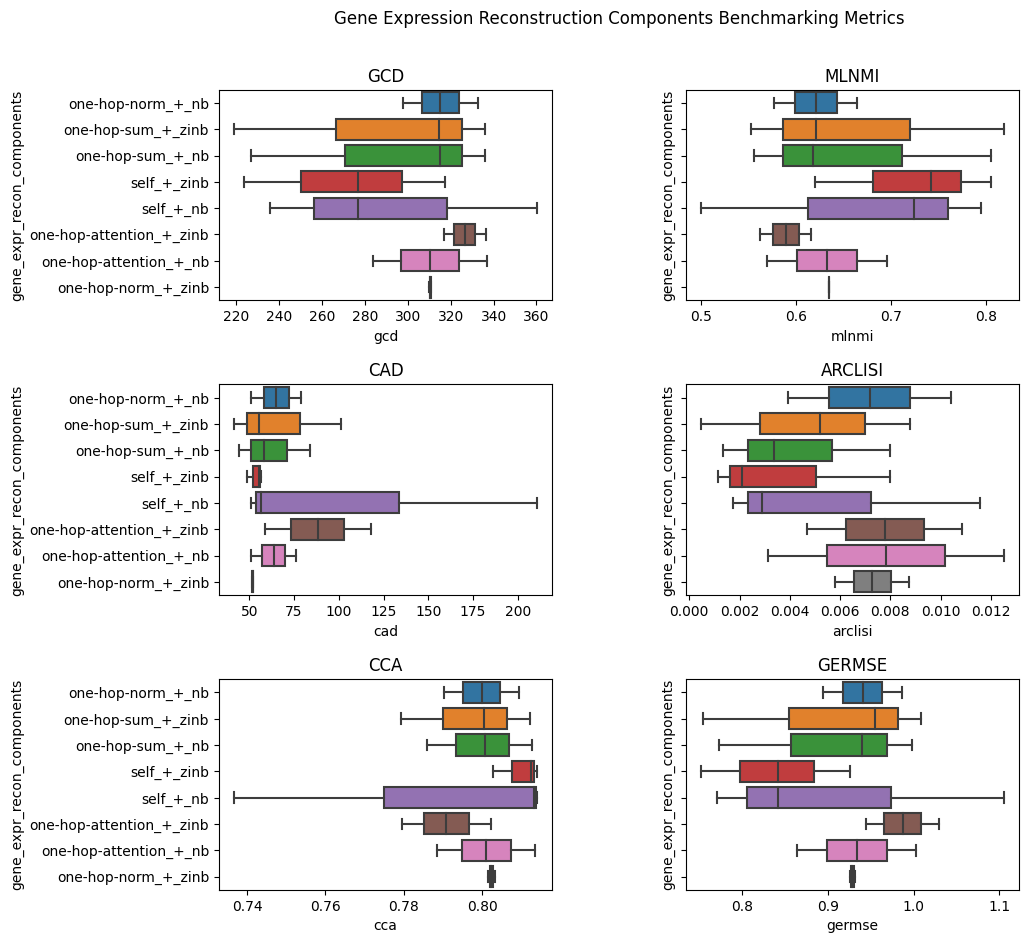

In [ ]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Gene Expression Reconstruction Components Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="gene_expr_recon_components")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="gene_expr_recon_components")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="gene_expr_recon_components")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="gene_expr_recon_components")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="gene_expr_recon_components")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="gene_expr_recon_components")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [45]:
def plot_benchmarking_metrics(fig_title,
                              df,
                              y_col_name,
                              save_fig=False,
                              save_dir="../figures",
                              file_name="benchmarking_metrics.png"):
    fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
    fig.suptitle(fig_title)
    
    # Graph Connectivity Distance
    sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y=y_col_name)
    axes[0, 0].set_title("GCD")

    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y=y_col_name)
    axes[0, 1].set_title("MLNMI")

    # Cell-Type Affinity Distance
    sns.boxplot(data=df, ax=axes[1, 0], x="cad", y=y_col_name)
    axes[1, 0].set_title("CAD")

    # Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
    sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y=y_col_name)
    axes[1, 1].set_title("ARCLISI")

    # Cell Classification Accuracy
    sns.boxplot(data=df, ax=axes[2, 0], x="cca", y=y_col_name)
    axes[2, 0].set_title("CCA")

    # Gene Expression Regression Mean Squared Error
    sns.boxplot(data=df, ax=axes[2, 1], x="germse", y=y_col_name)
    axes[2, 1].set_title("GERMSE")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.4)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}_{current_timestamp}.png",
                    bbox_inches='tight')

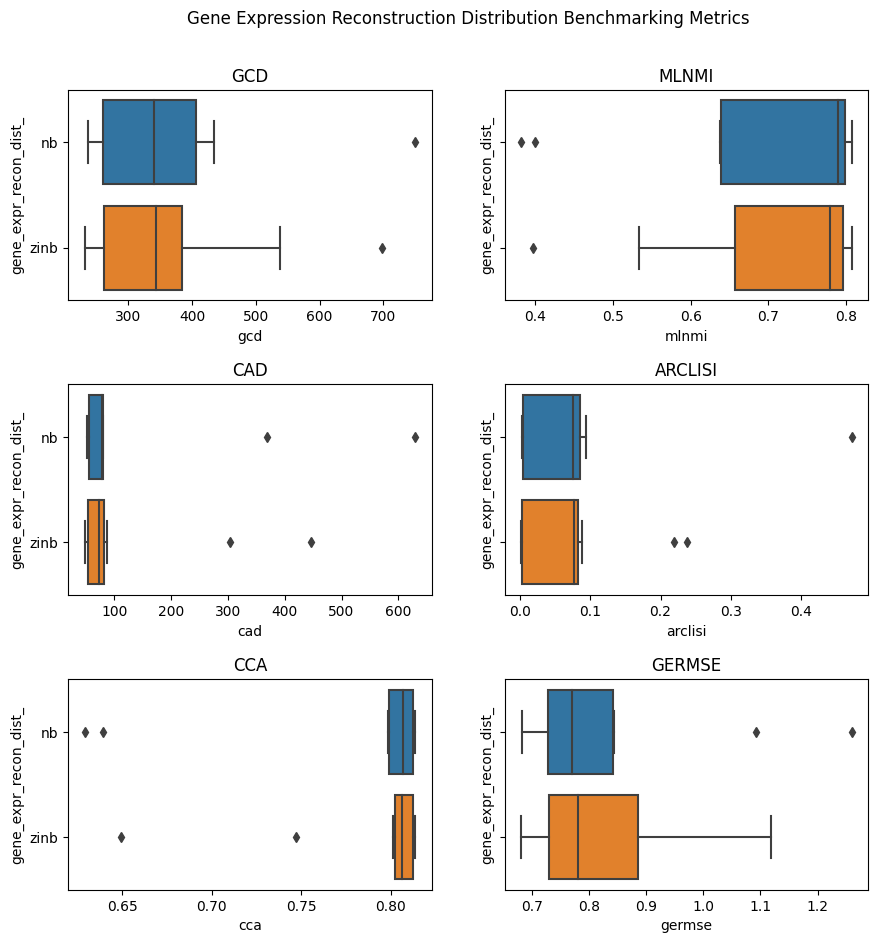

In [46]:
plot_benchmarking_metrics(fig_title="Gene Expression Reconstruction Distribution Benchmarking Metrics",
                          df=df,
                          y_col_name="gene_expr_recon_dist_",
                          save_fig=False)

In [22]:
experiment_name = "benchmark_conv_layer_encoder"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

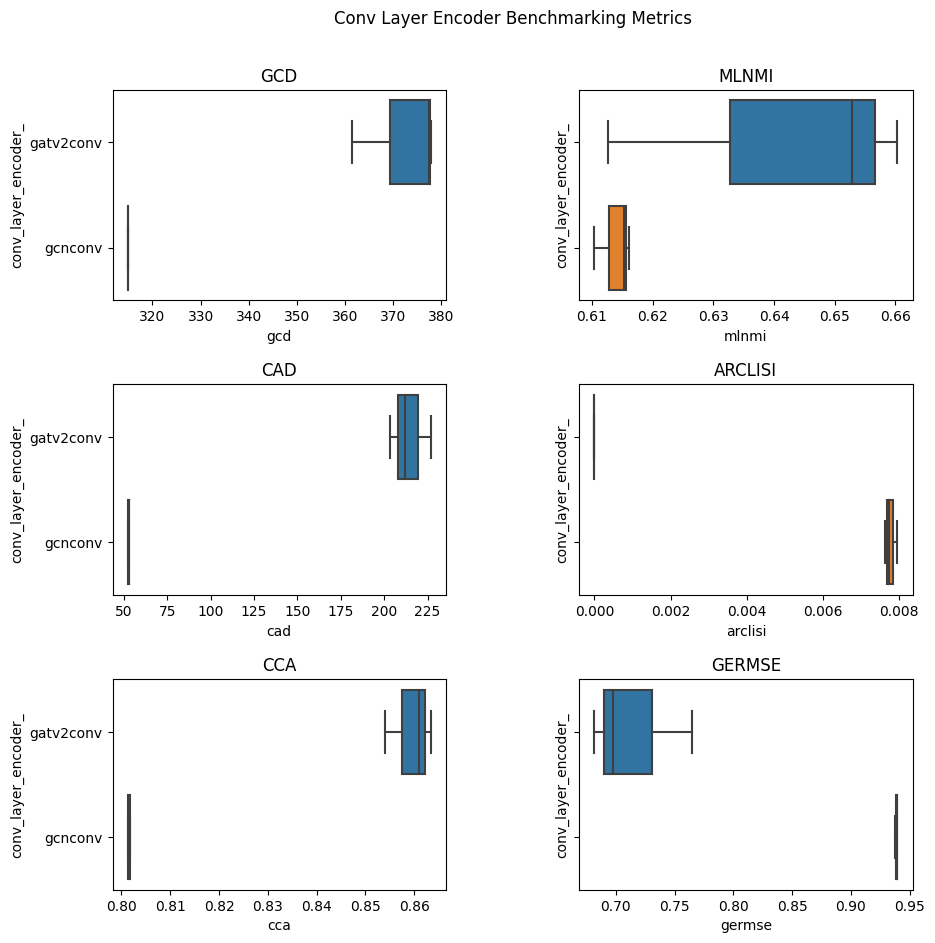

In [23]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Conv Layer Encoder Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="conv_layer_encoder_")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="conv_layer_encoder_")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="conv_layer_encoder_")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="conv_layer_encoder_")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="conv_layer_encoder_")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="conv_layer_encoder_")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)